In this notebook we will test the keyword extraction module 

In [6]:
## IMPORTS
from src.pipeline.keyword_extraction import keyword_extraction
from utils.task import Task
import numpy as np
import json
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from dotenv import load_dotenv
from utils.prompt import load_prompt
import tiktoken

load_dotenv()

In [2]:
# Function to load JSON data
def load_json_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data


# Function to create task object
def create_task(example):
    return Task(example)


In [16]:
filepath = "C:/Users\yousf\Bureau\ConvergenceAI\CHESS_Impl\data\subsampled_dev_set\sub_sampled_bird_dev_set.json"
data = load_json_data(filepath)
example = data[11]
example

{'question_id': 111,
 'db_id': 'financial',
 'question': 'How many accounts were opened in Litomerice in 1996?',
 'evidence': 'A2 refers to district name; Litomerice is one of district names.',
 'SQL': "SELECT COUNT(T2.account_id) FROM district AS T1 INNER JOIN account AS T2 ON T1.district_id = T2.district_id WHERE STRFTIME('%Y', T2.date) = '1996' AND T1.A2 = 'Litomerice'",
 'difficulty': 'simple'}

In [17]:
# Create task object
task = create_task(example)
model = ("gpt-4")
llm_response = keyword_extraction(task, model)
llm_response

['accounts opened', 'Litomerice', '1996', 'A2', 'district name']

In [5]:
#choose the model for the task of keyword extraction 
model = "llama-3"

# Initialize a list to store the results
results = []
for i in range(10):
    task = create_task(data[i])
    keywords = keyword_extraction(task, model)

    results.append({
        "question": task.question,
        "hint": task.evidence,
        "keywords": keywords
    })

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=["question", "hint", "keywords"])
df



,question,hint,keywords
0,Among the schools with the average score in Ma...,,"[SAT test, Math, average score, 560, charter-f..."
1,In Los Angeles how many schools have more than...,,"[Los Angeles, schools, free meals, 500, 700, f..."
2,Name schools in Riverside which the average of...,Average of average math = sum(average math sco...,"[Riverside, schools, average math score, SAT, ..."
3,What is the administrator's email address of t...,Charted school means `Charter School (Y/N)` = ...,"[Charter School, Y/N, table, frpm, Enrollment,..."
4,What is the telephone number for the school wi...,Fresno Unified is a name of district;,"[telephone number, school, lowest average scor..."
5,What is the average math score of the school w...,Average score for all subjects can be computed...,"[average math score, school, lowest average sc..."
6,What is the city location of the high school l...,High school can be represented as EILCode = 'HS',"[city location, high school, Lunch Provision 2..."
7,In which city can you find the school in the s...,State of California refers to state = 'CA',"[school, California, state, CA, lowest latitud..."
8,How many male customers who are living in Nort...,Male means that gender = 'M'; A3 refers to reg...,"[male customers, North Bohemia, average salary..."
9,List out the clients who choose statement of i...,'POPLATEK PO OBRATU' stands for issuance after...,"[clients, choose, tatement, issuance, after, t..."


## Case study for the Keyword exctraction module 

In [7]:
# Step 1: Select 15 random samples
random_state = 42
random.seed(random_state)
random_samples = random.sample(data, 15)


In [9]:

#store this random subsampled set to use it in other tests 

subsampled_test_path = Path('C:/Users/yousf/Bureau/ConvergenceAI/CHESS_Impl/data/test/subsampled_test.json')
subsampled_test_path.parent.mkdir(parents=True, exist_ok=True)

with open(subsampled_test_path, 'w') as f:
    json.dump(random_samples, f, indent=4)

In [12]:
#store the extracted keywords in a JSON file 
res = []
model = "gpt-4"
for sample in tqdm(random_samples):
    task = create_task(sample)
    extracted_keywords = keyword_extraction(task, model)
    res.append(extracted_keywords)

keywords_path = Path('C:/Users/yousf/Bureau/ConvergenceAI/CHESS_Impl/data/test/extracted_keywords.json')
with open(keywords_path, 'w') as f:
    json.dump(res, f, indent=4)


100%|██████████| 15/15 [00:40<00:00,  2.69s/it]


In [7]:
# Step 2: Extract question and evidence and build a DataFrame
df = pd.DataFrame([{
    'question': sample['question'],
    'evidence': sample['evidence']
} for sample in random_samples])
df['keywords_annotation'] = None


In [17]:
# Step 3 : manual annotation of keywords 
df.to_csv("C:/Users/yousf/Bureau/ConvergenceAI/CHESS_Impl/data/test/keywords_annotated_samples")


In [6]:
# Step 4 : Extract Keywords 
annotated_df = pd.read_csv("C:/Users/yousf/Bureau/ConvergenceAI/CHESS_Impl/data/test/keywords_annotated_samples")
annotated_df


,Unnamed: 0,question,evidence,keywords_annotation
0,0,List out the atom id that belongs to the TR346...,NaN,"[""atom id"",""TR346 molecule"",""molecule"",""bond t..."
1,1,What is the city location of the high school l...,High school can be represented as EILCode = 'HS',"[""city location"",""high school"",""level school"",..."
2,2,Please give the full name of the tallest hero ...,the tallest hero refers to MAX(height_cm); pub...,"[""full name"",""tallest hero"",""Marvel Comics"",""M..."
3,3,"How many elders obtained the ""Supporter"" badge?","""Supporter"" is the Name of badge;elders refers...","[""elders"",""Supporter badge"",""Name of badge"",""A..."
4,4,How many users from New York have a teacher an...,"""Supporter"" and ""Teachers"" are both Name of ba...","[""users"",""New York"",""teacher badge"",""supporter..."
5,5,What is the description about the ruling of ca...,Ancestor's Chosen' is the name of card; descri...,"[""description"",""ruling of card"",""Condemn"",""Anc..."
6,6,How many double bonds does TR006 have and is i...,label = '+' mean molecules are carcinogenic; l...,"[""double bonds"",""TR006"",""carcinogenic"",""label""..."
7,7,Write the full name of the club member with th...,"full name refers to first_name, last name","[""full name"",""club member"",""position"",""Secreta..."
8,8,Among all chemical compounds identified in the...,triple bond refers to bond_type = '#';,"[""chemical compounds"",""percent of compounds"",""..."
9,9,What was the potiential for Francesco Parravic...,Francesco Parravicini refers to player_name = ...,"[""potiential"",""Francesco Parravicini"",""2010/8/..."


In [7]:

def calculate_metrics(annotated_keywords, extracted_keywords):
    """
    Calculates precision, recall, and F1-score.

    Args:
        annotated_keywords (List[str]): Manually annotated keywords.
        extracted_keywords (List[str]): Keywords extracted by the model.

    Returns:
        Tuple[float, float, float]: Precision, recall, and F1-score.
    """
    annotated_set = set(annotated_keywords)
    extracted_set = set(extracted_keywords)

    true_positives = len(annotated_set & extracted_set)
    false_positives = len(extracted_set - annotated_set)
    false_negatives = len(annotated_set - extracted_set)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


def evaluate_models(df, models):
    """
    Evaluates multiple models on the given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing questions, evidence, and manual annotations.
        models (List[str]): List of model names to evaluate.

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics for each model.
    """
    results = []

    for model in tqdm(models):
        precisions, recalls, f1s = [], [], []

        for index, row in tqdm(df.iterrows()):
            task = create_task(random_samples[index])
            extracted_keywords = keyword_extraction(task, model)
            precision, recall, f1 = calculate_metrics(row['keywords_annotation'], extracted_keywords)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

        results.append({
            'model': model,
            'precision': np.mean(precisions),
            'recall': np.mean(recalls),
            'f1': np.mean(f1s)
        })

    return pd.DataFrame(results)


In [8]:
import ast

models = ['llama-3', 'mixtral', 'phi-3', 'gpt-4o', 'gpt-4o-mini', 'gpt-3.5', 'gpt-4', ]
annotated_df['keywords_annotation'] = annotated_df['keywords_annotation'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

res = evaluate_models(annotated_df, models)
res

  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:01,  1.32s/it]
2it [00:02,  1.26s/it]
3it [00:03,  1.17s/it]
4it [00:04,  1.02s/it]
5it [00:05,  1.06s/it]
6it [00:06,  1.01s/it]
7it [00:06,  1.32it/s]
8it [00:07,  1.23it/s]
9it [00:08,  1.14it/s]
10it [00:10,  1.09s/it]
11it [00:11,  1.19s/it]
12it [00:12,  1.20s/it]
13it [00:14,  1.31s/it]
14it [00:16,  1.46s/it]
15it [00:17,  1.15s/it]
 14%|█▍        | 1/7 [00:17<01:43, 17.29s/it]
0it [00:00, ?it/s]
1it [00:01,  1.14s/it]
2it [00:04,  2.46s/it]
3it [00:06,  2.45s/it]
4it [00:08,  1.99s/it]
5it [00:10,  1.91s/it]
6it [00:11,  1.69s/it]
7it [00:13,  1.81s/it]
8it [00:14,  1.71s/it]
9it [00:16,  1.63s/it]
10it [00:18,  1.74s/it]
11it [00:21,  2.11s/it]
12it [00:22,  1.94s/it]
13it [00:25,  2.09s/it]
14it [00:26,  1.83s/it]
15it [00:27,  1.85s/it]
 29%|██▊       | 2/7 [00:45<01:57, 23.43s/it]
0it [00:00, ?it/s]
1it [00:00,  1.20it/s]
2it [00:01,  1.02s/it]
3it [00:02,  1.06it/s]
4it [00:03,  1.16it/s]
5it [00:04,  1.16it

,model,precision,recall,f1
0,llama-3,0.728704,0.711166,0.711022
1,mixtral,0.681208,0.725570,0.687429
2,phi-3,0.796402,0.693612,0.737280
3,gpt-4o,0.791931,0.810981,0.792995
4,gpt-4o-mini,0.787317,0.772900,0.773166
5,gpt-3.5,0.732407,0.672244,0.695025
6,gpt-4,0.839408,0.841635,0.835058


In [9]:
# Plotting the results
def plot_evaluation_results(results):
    """
    Plots the precision, recall, and F1-score for different models.
    
    Args:
        results (pd.DataFrame): DataFrame containing the evaluation metrics for each model.
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 7))

    # Convert the DataFrame to long format for easier plotting with seaborn
    results_long = pd.melt(results, id_vars=['model'], value_vars=['precision', 'recall', 'f1'],
                           var_name='metric', value_name='value')

    # Create the plot
    sns.barplot(x='model', y='value', hue='metric', data=results_long)

    # Add titles and labels
    plt.title('Model Evaluation Metrics')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(title='Metric')

    # Display the plot
    plt.tight_layout()
    plt.show()

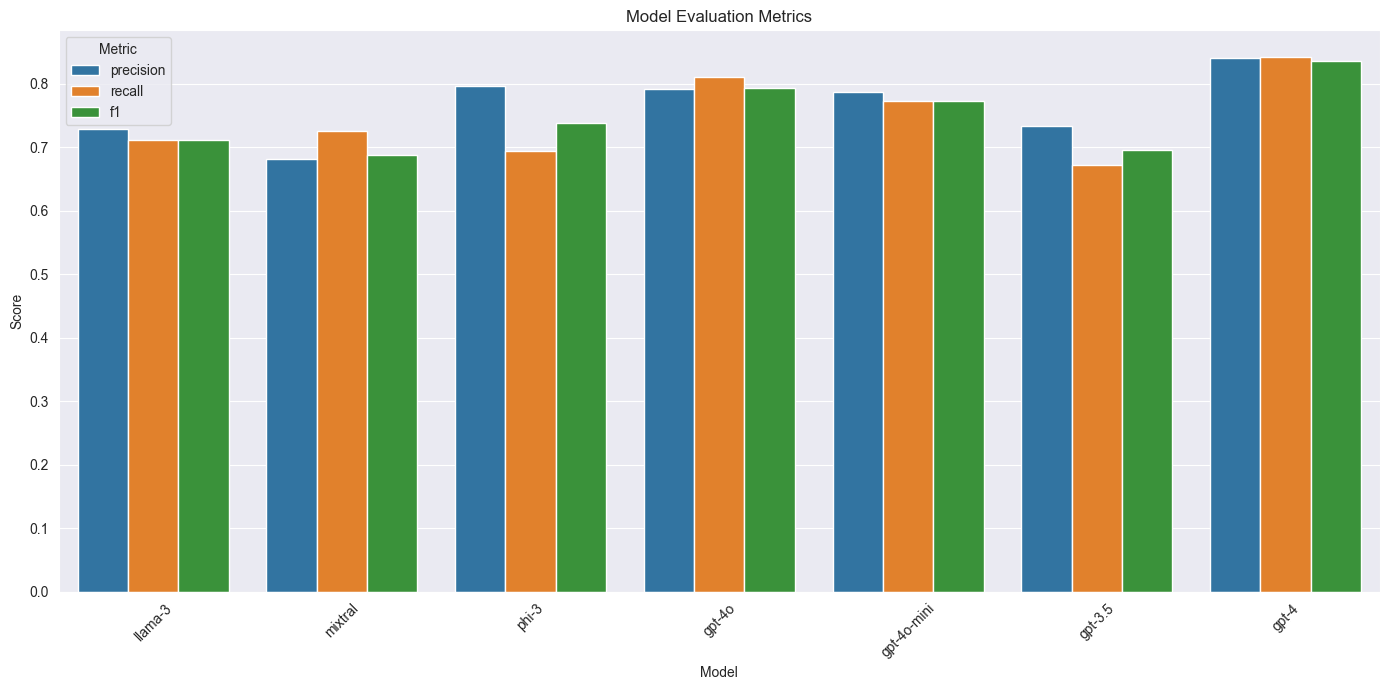

In [10]:
plot_evaluation_results(res)

## Cost Estimation per task

### gpt-4-turbo Pricing : 
- 10.00 / 1 million input tokens (or 0.01 / 1K input tokens)

- 30.00 / 1 million output tokens (or 0.03 / 1K output tokens) 
### gpt-3.5-turbo Pricing : 
- 1.50 / 1M input tokens (or 0.0015 / 1K input tokens)
- 2.00 / 1M output tokens (or 0.002 / 1K output tokens)


In [1]:

PROMPT_PATH = os.getenv("PROMPT_ROOT_PATH") + "\keyword_extraction.txt"
prompt = load_prompt(PROMPT_PATH)

In [4]:
def tokens_calc(example):
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(example))
    return num_tokens

In [5]:
tokens_calc(prompt)

650

The minimum number of tokens in the prompt is 650, and it has 2 variables Question and Hint.
So let's suppose that the final prompt after formatting will contain 700 tokens. 

For the output token estimation we will take an output example and suppose from it the average number of tokens from the output

In [6]:
output_example = "['accounts opened', 'Litomerice', '1996', 'A2', 'district name']"
tokens_calc(output_example)

21

Suppose the number of tokens in the output is 30 

In [12]:
## Price calculation per task
input_price_per_token_gpt4 = 0.01 / 1000
output_price_per_token_gpt4 = 0.03 / 1000
input_price_per_token_gpt3 = 0.0015 / 1000
output_price_per_token_gpt3 = 0.002 / 1000
price_gpt4 = 700 * input_price_per_token_gpt4 + 30 * output_price_per_token_gpt4
price_gpt3 = 700 * input_price_per_token_gpt3 + 30 *output_price_per_token_gpt3
print("estimated price per task(GPT-4):", price_gpt4, "$")
print("estimated price per task(GPT-3.5):", price_gpt3, "$")

estimated price per task(GPT-4): 0.0079 $
estimated price per task(GPT-3.5): 0.0011099999999999999 $
